# Classification of HiTS

In [40]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from astropy.table import Table
from metric_tools import *
from sklearn.externals import joblib
from statsmodels.robust import mad

%matplotlib inline
sns.set(style="white", color_codes=True, context="notebook", font_scale=1.4)

mainpath = '/Users/jorgetil/Astro/HITS'

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

##### Summary of numbers for HiTS catalogs

### Total detections:

* 2015: detection catalog with ~15 millions objects
    * ~1.9 millions of lightcurves with >= 15 data points
    * 2918 items with labels for variability obtaind from cross-match with SDSS, VSX, CSS, GCVS, RR-Lyrae from Medina et al. and Supernovae from HiTS, plus visual inspection of non-variables (within survey sensitivity), plus transfer from MACHO and active learning.

### LC examples

Non Periodic                                            | Periodic
 :------------------------:|:---------------------------:
<img src="lc_examples_nonP.png" style="width: 500px;"/> | <img src="lc_examples_P.png" style="width: 500px;"/>

## FATS features

* Feature analysis for time series python package with more than 60 features.
* Period estimation from Lomb-Scargle (implemented in FATS), Generalized Lomb-Scargle (gatspy) and Correntropy Kernel Periodogram (P4J)
* Color indexes from g,r and i bands

## Data set

## Training set

In [3]:
table_file = '%s/tables/Blind14A_U_Blind15A_only_labeled.csv'\
              %(mainpath)
label_samp = pd.read_csv(table_file)
label_samp = label_samp.set_index('internalID')
print label_samp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8921 entries, Blind15A_35_N23_1408_3473 to Blind14A_40_S31_0322_2893
Data columns (total 74 columns):
ID                                 8921 non-null object
raMedian                           8921 non-null float64
decMedian                          8921 non-null float64
X                                  8921 non-null float64
Y                                  8921 non-null float64
spCl                               3812 non-null object
spSubCl                            2735 non-null object
Var_Type                           8921 non-null object
Var_subType                        256 non-null object
Amplitude                          8921 non-null float64
AndersonDarling                    8921 non-null float64
Autocor_length                     8921 non-null float64
Beyond1Std                         8921 non-null float64
CAR_mean                           8921 non-null float64
CAR_sigma                          8921 non-null float64
CAR_

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
label_samp.head()

,ID,raMedian,decMedian,X,Y,spCl,spSubCl,Var_Type,Var_subType,Amplitude,...,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i
internalID,,,,,,,,,,,,,,,,,,,,,
Blind15A_35_N23_1408_3473,HiTS101111+012944,152.798620,1.495657,1408.947738,3473.264517,GALAXY,NaN,SNe,NaN,0.197745,...,0.351900,-0.239747,0.269412,0.655449,0.102917,0.776512,0.756380,1.984759,1.422029,0.56273
Blind14A_19_N19_1720_3738,HiTS104506-002747,161.278461,-0.463066,1720.768139,3738.788840,GALAXY,STARBURST,NV,NaN,0.009567,...,0.230762,-0.035108,0.091238,-1.084781,0.006477,0.866802,0.685588,NaN,NaN,NaN
Blind14A_20_S9_1104_2980,HiTS104445+022013,161.189658,2.337103,1104.247578,2980.433586,GALAXY,NaN,NV,NaN,0.012085,...,0.228233,0.193119,0.091244,-0.700074,0.006947,0.846997,0.767762,NaN,NaN,NaN
Blind14A_21_N5_0662_2268,HiTS105721+020221,164.337947,2.039295,662.979512,2268.392342,GALAXY,STARFORMING,NV,NaN,0.017333,...,0.197445,-0.521790,0.091252,0.061091,0.009662,0.828883,0.747913,NaN,NaN,NaN
Blind14A_22_N6_0262_1631,HiTS105333-000140,163.390026,-0.027815,262.340695,1631.238769,GALAXY,NaN,NV,NaN,0.012767,...,0.201758,0.390108,0.091211,0.132114,0.006689,0.844004,0.775294,NaN,NaN,NaN


In [5]:
label_samp.Var_Type.value_counts()

NV        5000
QSO       3495
RRLYR      177
EB         110
CV          94
SNe         29
MISC         7
ROTVAR       5
ZZ           2
DSCT         1
LPV          1
Name: Var_Type, dtype: int64

In [6]:
for label in set(label_samp.Var_Type):
    print label
    field = [f[:7] for f in label_samp.query('Var_Type == "%s"' % (label)).index]
    field = pd.Series(field)
    print field.value_counts()
    print '___________________________'

SNe
Blind15    22
Blind14     7
dtype: int64
___________________________
MISC
Blind15    4
Blind14    3
dtype: int64
___________________________
LPV
Blind15    1
dtype: int64
___________________________
DSCT
Blind15    1
dtype: int64
___________________________
QSO
Blind15    2337
Blind14    1158
dtype: int64
___________________________
EB
Blind15    92
Blind14    18
dtype: int64
___________________________
ROTVAR
Blind15    5
dtype: int64
___________________________
ZZ
Blind15    2
dtype: int64
___________________________
RRLYR
Blind15    132
Blind14     45
dtype: int64
___________________________
CV
Blind15    64
Blind14    30
dtype: int64
___________________________
NV
Blind14    4996
Blind15       4
dtype: int64
___________________________


In [7]:
print 'original shape:', label_samp.shape
cols = label_samp.columns.values
FATS_feats_all = cols[9:]
FATS_feats_gr = FATS_feats_all[(FATS_feats_all != 'g-i') & (FATS_feats_all != 'r-i')]
FATS_feats_non = cols[9:-3]
FATS_feats_non_mean = FATS_feats_non[(FATS_feats_non != 'Mean') & 
                                     (FATS_feats_non != 'CAR_mean') & 
                                     (FATS_feats_non != 'Meanvariance')]
print FATS_feats_non_mean

label_samp_all = label_samp.dropna(subset=FATS_feats_all)
label_samp_gr = label_samp.dropna(subset=FATS_feats_gr)
label_samp_non = label_samp.dropna(subset=FATS_feats_non)

print len(FATS_feats_all)

original shape: (8921, 74)
['Amplitude' 'AndersonDarling' 'Autocor_length' 'Beyond1Std' 'CAR_sigma'
 'CAR_tau' 'Con' 'Eta_e' 'FluxPercentileRatioMid20'
 'FluxPercentileRatioMid35' 'FluxPercentileRatioMid50'
 'FluxPercentileRatioMid65' 'FluxPercentileRatioMid80'
 'Freq1_harmonics_amplitude_0' 'Freq1_harmonics_amplitude_1'
 'Freq1_harmonics_amplitude_2' 'Freq1_harmonics_amplitude_3'
 'Freq1_harmonics_rel_phase_0' 'Freq1_harmonics_rel_phase_1'
 'Freq1_harmonics_rel_phase_2' 'Freq1_harmonics_rel_phase_3'
 'Freq2_harmonics_amplitude_0' 'Freq2_harmonics_amplitude_1'
 'Freq2_harmonics_amplitude_2' 'Freq2_harmonics_amplitude_3'
 'Freq2_harmonics_rel_phase_0' 'Freq2_harmonics_rel_phase_1'
 'Freq2_harmonics_rel_phase_2' 'Freq2_harmonics_rel_phase_3'
 'Freq3_harmonics_amplitude_0' 'Freq3_harmonics_amplitude_1'
 'Freq3_harmonics_amplitude_2' 'Freq3_harmonics_amplitude_3'
 'Freq3_harmonics_rel_phase_0' 'Freq3_harmonics_rel_phase_1'
 'Freq3_harmonics_rel_phase_2' 'Freq3_harmonics_rel_phase_3' 'Gskew

In [8]:
print '#### TS without cleaning ####'
print label_samp.Var_Type.value_counts()
print '--------------------------------'
print '#### TS all colors ####'
print label_samp_all.Var_Type.value_counts()
print '--------------------------------'
print '#### TS with g-r ####'
print label_samp_gr.Var_Type.value_counts()
print '--------------------------------'
print '#### TS without colors ####'
print label_samp_non.Var_Type.value_counts()

#### TS without cleaning ####
NV        5000
QSO       3495
RRLYR      177
EB         110
CV          94
SNe         29
MISC         7
ROTVAR       5
ZZ           2
DSCT         1
LPV          1
Name: Var_Type, dtype: int64
--------------------------------
#### TS all colors ####
QSO       1790
RRLYR      115
EB          74
CV          49
SNe         16
ROTVAR       5
MISC         4
ZZ           1
LPV          1
NV           1
Name: Var_Type, dtype: int64
--------------------------------
#### TS with g-r ####
QSO       2220
RRLYR      131
EB          91
CV          63
SNe         19
ROTVAR       5
MISC         4
NV           4
ZZ           2
LPV          1
Name: Var_Type, dtype: int64
--------------------------------
#### TS without colors ####
NV        5000
QSO       3495
RRLYR      177
EB         110
CV          94
SNe         29
MISC         7
ROTVAR       5
ZZ           2
DSCT         1
LPV          1
Name: Var_Type, dtype: int64


### Feature selection from pyFmax

* pyFmax is a python package that di Feature selection based on feature contrasts

In [9]:
def test_n_estimators(X, y, hiperparam='n_estimators', test_range=np.arange(0,100,10), plot=True):
    test_range[0] = 1
    if hiperparam == 'n_estimators':
        print "N estimators = ", test_range
    else:
        print "Max depth = ", test_range
    scores = np.zeros(len(test_range))
    stds = np.zeros(len(test_range))
    oob_error = np.zeros(len(test_range))
    
    for i in range(len(test_range)):
        N = test_range[i]
        if hiperparam == 'n_estimators':
            rf_clf = RandomForestClassifier(n_estimators=N, criterion='entropy',
                               max_features='sqrt', max_depth=10, n_jobs=2,
                                min_samples_leaf=1, oob_score=True,
                                class_weight='balanced_subsample')
        else:
            rf_clf = RandomForestClassifier(n_estimators=50, criterion='entropy',
                               max_features='sqrt', max_depth=N, n_jobs=2,
                                min_samples_leaf=1, oob_score=True,
                                class_weight='balanced_subsample')
        ss = model_selection.StratifiedShuffleSplit(n_splits=10, train_size=2./3.,
                                                random_state=10)
        scores_i = model_selection.cross_val_score(rf_clf, X, y, cv=ss, n_jobs=3, verbose=1, 
                                                   scoring='accuracy')
        scores[i] = scores_i.mean()
        stds[i] = scores_i.std()
        rf_clf.fit(X, y)
        oob_error[i] = 1 - rf_clf.oob_score_
    
    if plot:
        fig, ax = plt.subplots(1,2,figsize=(14, 4))
        ax[0].plot(test_range, oob_error)
        ax[0].set_xlabel(hiperparam)
        ax[0].set_ylabel("OOB error rate")
        ax[0].grid()
        ax[1].errorbar (test_range, scores, yerr = stds)
        ax[1].set_xlabel(hiperparam)
        ax[1].set_ylabel("Accuracy")
        ax[1].grid()
        plt.show()

## Bagging PU test - OneVsAll (Binary classification)

## Hierarchical approach

# Variable vs NonVariable

## Without QSO

In [10]:
remove_sn = ['Blind15A_08_S29_0364_0480', 'Blind15A_15_N22_1632_3972',
             'Blind15A_26_N10_1235_2658', 'Blind15A_26_S23_1632_1684',
             'Blind15A_34_N1_0805_2093', 'Blind15A_35_N5_1843_2802',
             'Blind15A_38_N21_1524_3494', 'Blind15A_35_N23_1408_3473',
             'Blind15A_39_S10_0859_1758', 'Blind15A_45_N8_1698_3074',
             'Blind15A_46_S24_0879_0613', 'Blind15A_47_S27_0978_3515',
             'Blind14A_13_S2_0714_1701', 'Blind14A_21_S5_0868_2177',
             'Blind14A_24_N12_0134_1258', 'Blind14A_25_N4_1650_2829',
             'Blind14A_34_S17_1342_2536']
print len(remove_sn)
label_samp_non.drop(remove_sn, inplace=True)

17


In [11]:
syn_nv = pd.read_csv('%s/tables/synthetics/Syntectic_NV_features_noise.csv' % mainpath)
#syn_nv['g-i'] = label_samp_all.sample(len(syn_nv), random_state=1)['g-i'].values
#syn_nv['g-r'] = label_samp_all.sample(len(syn_nv), random_state=2)['g-r'].values
#syn_nv['r-i'] = label_samp_all.sample(len(syn_nv), random_state=3)['r-i'].values

syn_dsct = pd.read_csv('%s/tables/synthetics/Syntectic_DSCT_features_noise.csv' % mainpath).sample(1000)
syn_rotv = pd.read_csv('%s/tables/synthetics/Syntectic_ROTVAR_features_noise.csv' % mainpath).sample(1000)
syn_rrly = pd.read_csv('%s/tables/synthetics/Syntectic_RRLYR_features_noise.csv' % mainpath).sample(1000)
syn_eb = pd.read_csv('%s/tables/synthetics/Syntectic_EB_features_noise.csv' % mainpath)

syn_rotv = syn_rotv.query('Period_fit < .1')
syn_dsct = syn_dsct.query('Period_fit < .1')
syn_rrly = syn_rrly.query('Period_fit < .1')
syn_eb = syn_eb.query('Period_fit < .02')
#syn_rrly2 = syn_rrly2.query('Period_fit < .3')
print syn_rrly.shape

label_samp_all_gpf = label_samp_non.query('(Var_Type == "RRLYR" or\
                                               Var_Type == "EB" or\
                                               Var_Type == "ROTVAR" or\
                                               Var_Type == "DSCT" or\
                                               Var_Type == "ZZ" or\
                                               Var_Type == "LPV") and\
                                               Period_fit < .5 or\
                                              (Var_Type != "RRLYR" and\
                                               Var_Type != "EB" and\
                                               Var_Type != "ROTVAR" and\
                                               Var_Type != "DSCT" and\
                                               Var_Type != "ZZ" and\
                                               Var_Type != "LPV")')
#label_samp_all_gpf[cols].to_csv('%s/tables/HiTS_training_set_goodP.csv'\
#                        %(mainpath))
print label_samp_all_gpf.Var_Type.value_counts()

syn_sample = pd.concat([label_samp_all_gpf, syn_nv, syn_rotv, syn_dsct, syn_eb, syn_rrly], axis=0)
print syn_sample.Var_Type.value_counts()
#syn_sample[cols].to_csv('%s/tables/HiTS_training_set_full_DA_goodP.csv'\
#                        %(mainpath))
syn_sample_noqso = syn_sample.query('~(Var_Type == "QSO" or Var_Type == "CV")')
print syn_sample_noqso.Var_Type.value_counts()

(143, 64)
NV        5000
QSO       3495
RRLYR      134
CV          94
EB          87
SNe         12
MISC         7
ROTVAR       5
DSCT         1
LPV          1
Name: Var_Type, dtype: int64
NV        9999
QSO       3495
EB         311
RRLYR      277
ROTVAR     168
DSCT       150
CV          94
SNe         12
MISC         7
LPV          1
Name: Var_Type, dtype: int64
NV        9999
EB         311
RRLYR      277
ROTVAR     168
DSCT       150
SNe         12
MISC         7
LPV          1
Name: Var_Type, dtype: int64


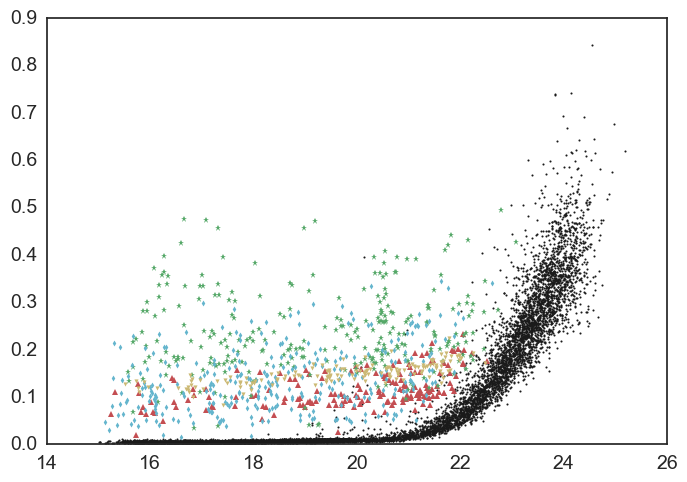

In [12]:
plt.plot(syn_sample_noqso.query('(Var_Type=="NV")').Mean, 
         syn_sample_noqso.query('(Var_Type=="NV")').Std, 'k.', ms=3)
plt.plot(syn_sample_noqso.query('(Var_Type=="ROTVAR")').Mean,
         syn_sample_noqso.query('(Var_Type=="ROTVAR")').Std, 'r^', ms=5)
plt.plot(syn_sample_noqso.query('(Var_Type=="RRLYR")').Mean,
         syn_sample_noqso.query('(Var_Type=="RRLYR")').Std, 'g*', ms=5)
plt.plot(syn_sample_noqso.query('(Var_Type=="EB")').Mean,
         syn_sample_noqso.query('(Var_Type=="EB")').Std, 'cd', ms=3)
plt.plot(syn_sample_noqso.query('(Var_Type=="DSCT")').Mean,
         syn_sample_noqso.query('(Var_Type=="DSCT")').Std, 'yv', ms=3)
plt.show()

In [13]:
y_var = conv_into_binary_class(syn_sample_noqso['Var_Type'].values,
                             neg_bool=True, neg_label='NV')
print'Var/nonVar:',
print '%i/%i' % (y_var[y_var==1].shape[0],
                 y_var[y_var==0].shape[0])

Var/nonVar: 926/9999


N estimators =  [ 1 10 20 30 40 50 60 70 80 90]


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    6.6s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    7.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    9.9s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   11.0s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   11.0s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   12.0s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   13.7s finished


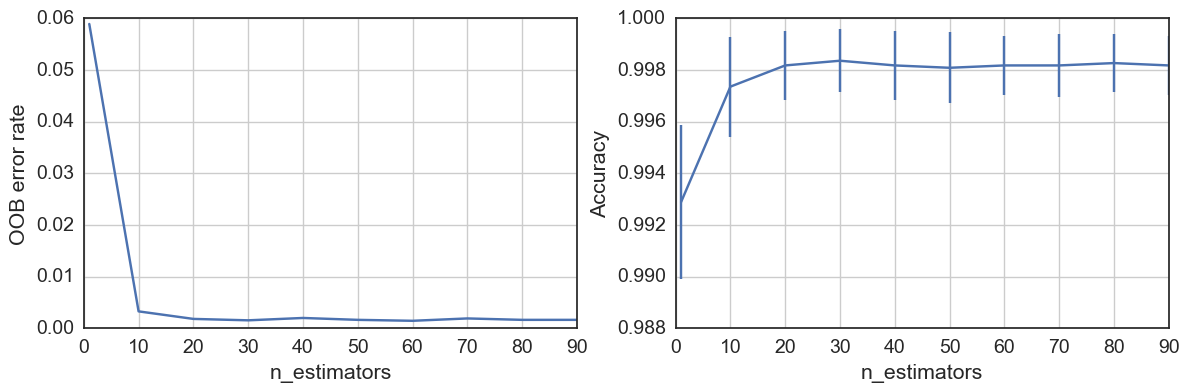

In [25]:
test_n_estimators(syn_sample_noqso[FATS_feats_non], y_var)

Max depth =  [ 1  2  4  6  8 10 12 14 16 18]


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.8s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.9s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    7.0s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    7.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    7.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    8.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    6.3s finished


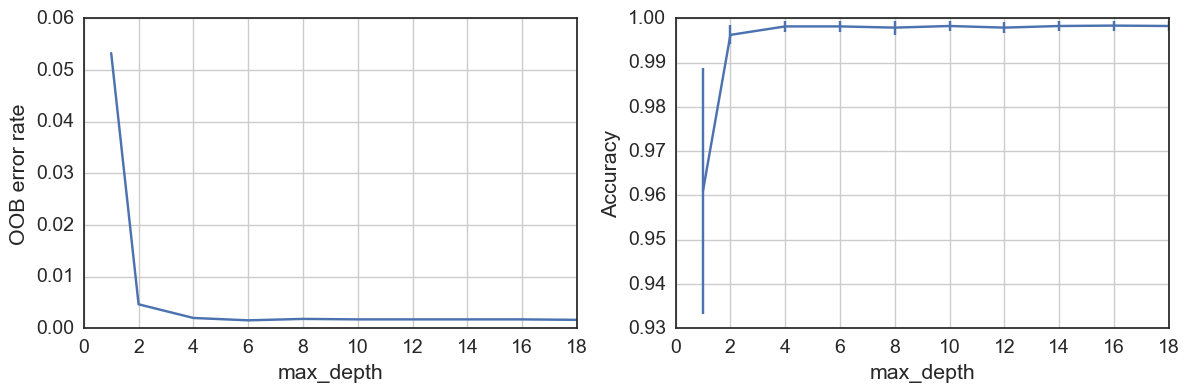

In [26]:
test_n_estimators(syn_sample_noqso[FATS_feats_non], y_var,
                  hiperparam='max_depth', test_range=np.arange(0,20,2))

In [14]:
RFC = RandomForestClassifier(n_estimators=30, criterion='entropy',
                           max_features='sqrt', max_depth=4, n_jobs=2,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced_subsample')

ss = model_selection.StratifiedShuffleSplit(n_splits=10, train_size=2./3.,
                                            random_state=10)

scores = model_selection.cross_val_score(RFC, syn_sample_noqso[FATS_feats_non],
                                         y_var, scoring='accuracy', cv=ss, n_jobs=2, verbose=1)
predict_class_v = model_selection.cross_val_predict(RFC, syn_sample_noqso[FATS_feats_non],
                                   y_var, cv=10, n_jobs=2, verbose=1, method='predict')
predict_proba_v = model_selection.cross_val_predict(RFC, syn_sample_noqso[FATS_feats_non],
                                   y_var, cv=10, n_jobs=2, verbose=1, method='predict_proba')

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    5.2s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    5.5s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    6.6s finished


Accuracy =  0.998170173833 +- 0.00135703540478
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      9999
          1       1.00      0.98      0.99       926

avg / total       1.00      1.00      1.00     10925



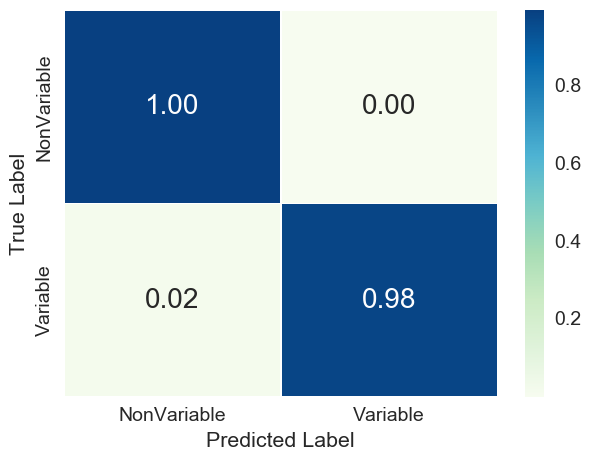

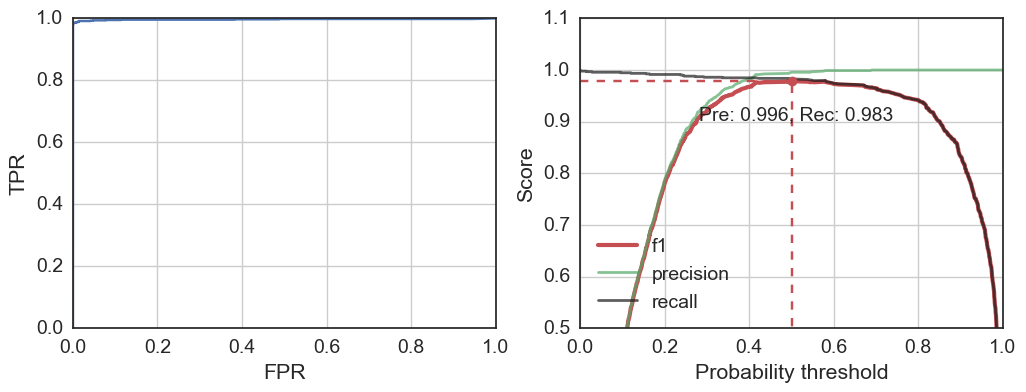

In [15]:
print "Accuracy = ", scores.mean(), "+-", scores.std()
print metrics.classification_report(y_var, predict_class_v)
save_path = '%s/figures/conf_matrix_var_nonvar_RFC_orgTS.pdf' % (mainpath)
conf_matrix(true=y_var, predict=predict_class_v, classes=[0,1], save=save_path, normalized=True,
           class_names=['NonVariable', 'Variable'])

ROC_F1_thresh_curves_binary(y_var.ravel(), predict_proba_v[:, 1])

In [16]:
print len(FATS_feats_all)
RFC_varNonQSO_save = RandomForestClassifier(n_estimators=30, criterion='entropy',
                           max_features='sqrt', max_depth=4, n_jobs=2,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced_subsample')

RFC_varNonQSO_save.fit(syn_sample_noqso[FATS_feats_non], y_var)
joblib.dump(RFC_varNonQSO_save, '%s/models/RFC_variable_DA_nonQSO.pkl' % mainpath) 

feat_imp = pd.DataFrame(np.array([FATS_feats_non, RFC_varNonQSO_save.feature_importances_]).T,
                        columns=['feat_name','feat_score'])
feat_imp.sort_values('feat_score', ascending=False).head(10)

65


,feat_name,feat_score
51,Period_fit,0.203383
53,Psi_eta,0.112163
61,StetsonK_AC,0.0793916
49,PeriodLS,0.0718637
42,Meanvariance,0.057263
54,Q31,0.0481165
41,Mean,0.0411454
22,Freq2_harmonics_amplitude_0,0.0386689
58,SmallKurtosis,0.0379507
43,MedianAbsDev,0.0330091


## we clean contaminating QSO

## static QSO --> NV

## final model for variable/non--variables

### clasificar qso

(3495, 75)
72


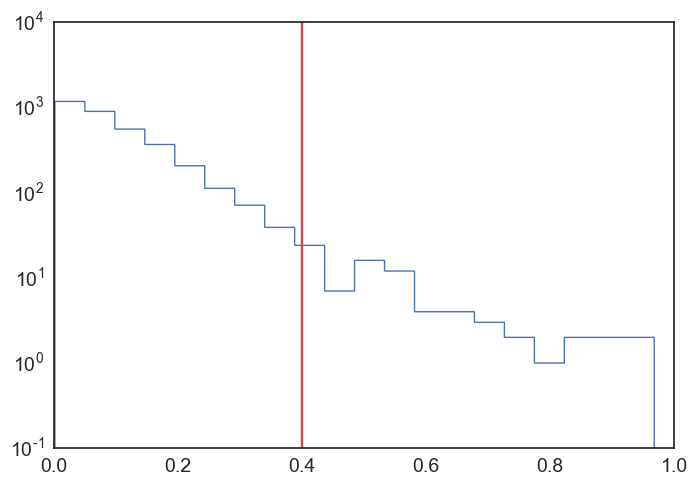

(72, 75)


In [20]:
qso_only = syn_sample.query('Var_Type == "QSO"')
print qso_only.shape

qso_pred = RFC_varNonQSO_save.predict_proba(qso_only[FATS_feats_non])
print len(qso_pred[qso_pred[:,1]>.4])
plt.hist(qso_pred[:,1], histtype='step', lw=1, color='b', bins=20, log=True)
plt.axvline(.4, color='r')
plt.show()

var_qso = qso_only[qso_pred[:,1] >= .4]
nvar_qso = qso_only[qso_pred[:,1] < .4]
print var_qso.shape

### Periodic vs NonPeriodic

In [21]:
label_samp_varonly = syn_sample.query('~(Var_Type == "QSO" or Var_Type == "NV")')
label_samp_varonly = pd.concat([label_samp_varonly, var_qso], axis=0)
print label_samp_varonly.shape

(1092, 75)


In [22]:
# removing periodic items with bad period fit (Period_fit > .5)
label_samp_varonly_goodPF = label_samp_varonly.query('(Var_Type == "RRLYR" or\
                                               Var_Type == "EB" or\
                                               Var_Type == "ROTVAR" or\
                                               Var_Type == "DSCT" or\
                                               Var_Type == "ZZ" or\
                                               Var_Type == "LPV") and\
                                               Period_fit < .5 or\
                                              (Var_Type != "RRLYR" and\
                                               Var_Type != "EB" and\
                                               Var_Type != "ROTVAR" and\
                                               Var_Type != "DSCT" and\
                                               Var_Type != "ZZ" and\
                                               Var_Type != "LPV")')
print label_samp_varonly_goodPF.Var_Type.value_counts()
#plt.hist(label_samp_varonly_goodPF.Period_fit, bins=20)
#plt.show()
y_periodic = conv_into_binary_class(label_samp_varonly_goodPF['Var_Type'].values,
                             pos_label=['RRLYR','EB','ROTVAR','DSCT','ZZ','LPV'])

EB        311
RRLYR     277
ROTVAR    168
DSCT      150
CV         94
QSO        72
SNe        12
MISC        7
LPV         1
Name: Var_Type, dtype: int64


N estimators =  [ 1 10 20 30 40 50 60 70 80 90]


[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.3s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.7s finished


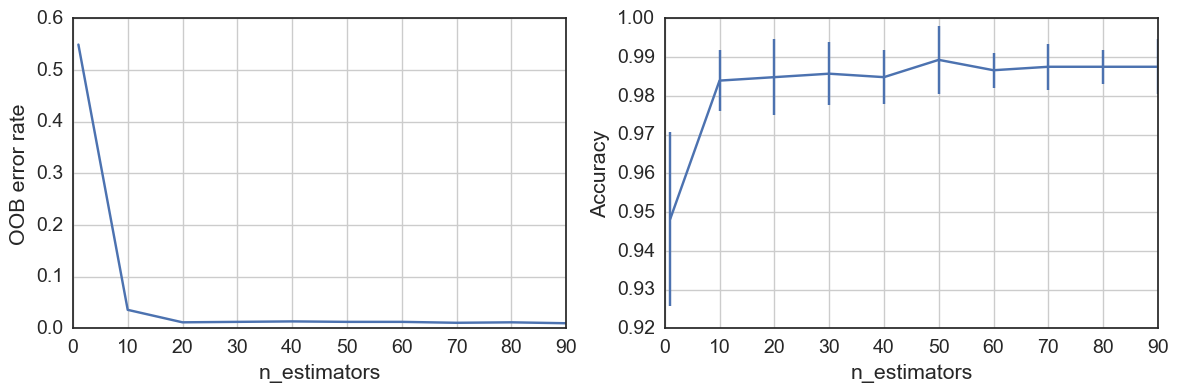

In [48]:
test_n_estimators(label_samp_varonly_goodPF[FATS_feats_non], y_periodic)

Max depth =  [ 1  2  4  6  8 10 12 14 16 18]


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.2s finished


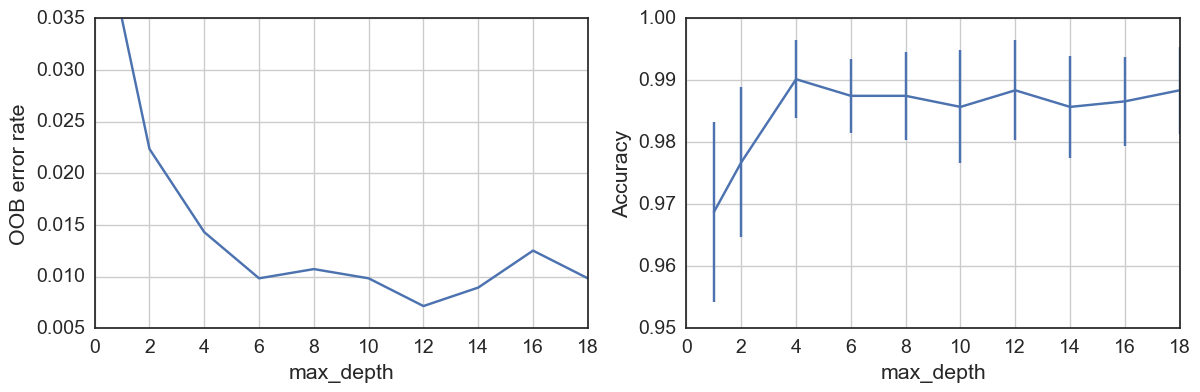

In [49]:
test_n_estimators(label_samp_varonly_goodPF[FATS_feats_non], y_periodic,
                  hiperparam='max_depth', test_range=np.arange(0,20,2))

In [39]:
print'Periodic/nonPeriodic:',
print '%i/%i' % (y_periodic[y_periodic==1].shape[0],
                 y_periodic[y_periodic==0].shape[0])

RFC = RandomForestClassifier(n_estimators=50, criterion='entropy',
                           max_features='sqrt', max_depth=4, n_jobs=2,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced')

scores = model_selection.cross_val_score(RFC, label_samp_varonly_goodPF[FATS_feats_non],
                                         y_periodic, scoring='f1', cv=ss, n_jobs=2, verbose=1)
predict_prob = model_selection.cross_val_predict(RFC, label_samp_varonly_goodPF[FATS_feats_non],
                                               y_periodic, cv=10, n_jobs=2, verbose=1, method='predict_proba')
predict_lab = [np.argmax(x) for x in predict_prob]

 Periodic/nonPeriodic: 907/185


[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    3.2s finished


F-1 =  0.989999888888 +- 0.00481322959654
             precision    recall  f1-score   support

          0       0.93      0.96      0.95       185
          1       0.99      0.99      0.99       907

avg / total       0.98      0.98      0.98      1092



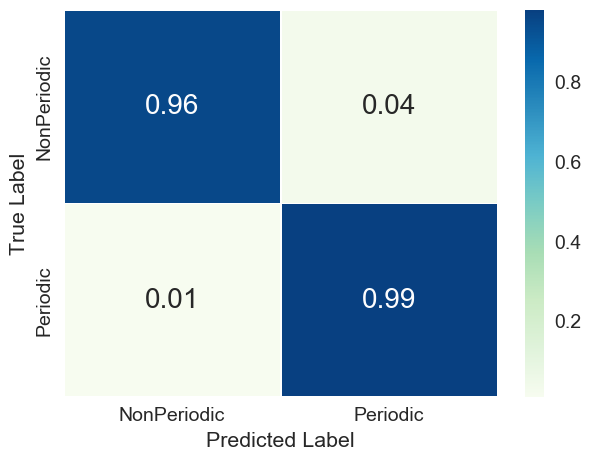

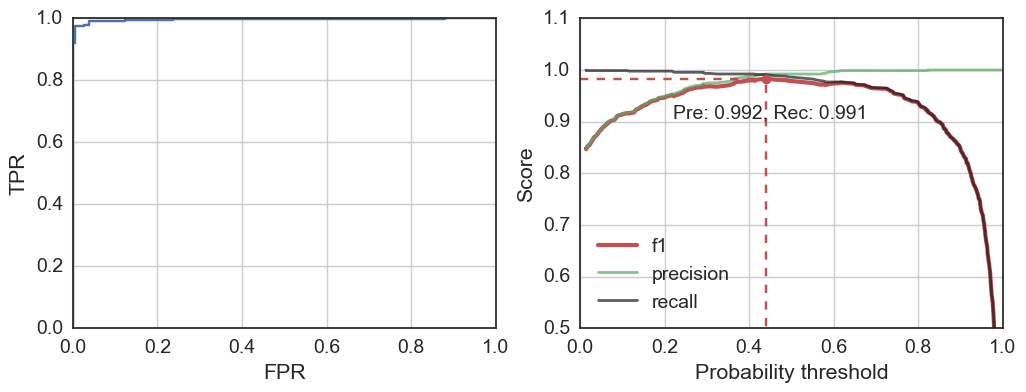

In [41]:
print "F-1 = ", np.median(scores), "+-", mad(scores)
print metrics.classification_report(y_periodic, predict_lab)
save_path = '%s/figures/conf_matrix_per_nonper_RFC.pdf' % (mainpath)
conf_matrix(true=y_periodic, predict=predict_lab, classes=[0,1], save=save_path, normalized=True,
           class_names=['NonPeriodic', 'Periodic'])
ROC_F1_thresh_curves_binary(y_periodic.ravel(), predict_prob[:, 1])

In [27]:
RFC_per_save = RandomForestClassifier(n_estimators=50, criterion='entropy',
                           max_features='sqrt', max_depth=4, n_jobs=2,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced_subsample')

RFC_per_save.fit(label_samp_varonly_goodPF[FATS_feats_non], y_periodic)
joblib.dump(RFC_per_save, '%s/models/RFC_periodics.pkl' % mainpath) 
feat_imp = pd.DataFrame(np.array([FATS_feats_non, RFC_per_save.feature_importances_]).T,
                        columns=['feat_name','feat_score'])
feat_imp.sort_values('feat_score', ascending=False).head(10)

,feat_name,feat_score
51,Period_fit,0.164944
5,CAR_sigma,0.121878
53,Psi_eta,0.0805061
14,Freq1_harmonics_amplitude_0,0.0534153
58,SmallKurtosis,0.0517044
54,Q31,0.0435245
42,Meanvariance,0.0434766
4,CAR_mean,0.0369579
49,PeriodLS,0.0340852
6,CAR_tau,0.0331525


### RotVar vs all periodic

### Periodic subclasses

## Periodic subclasses with data aumentation

In [30]:
sub_periodic = label_samp_varonly_goodPF.query('Var_Type == "RRLYR" or Var_Type == "EB" or \
                                                Var_Type == "DSCT" or Var_Type == "ROTVAR"')

N estimators =  [ 1 10 20 30 40 50 60 70 80 90]


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.5s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    4.1s finished


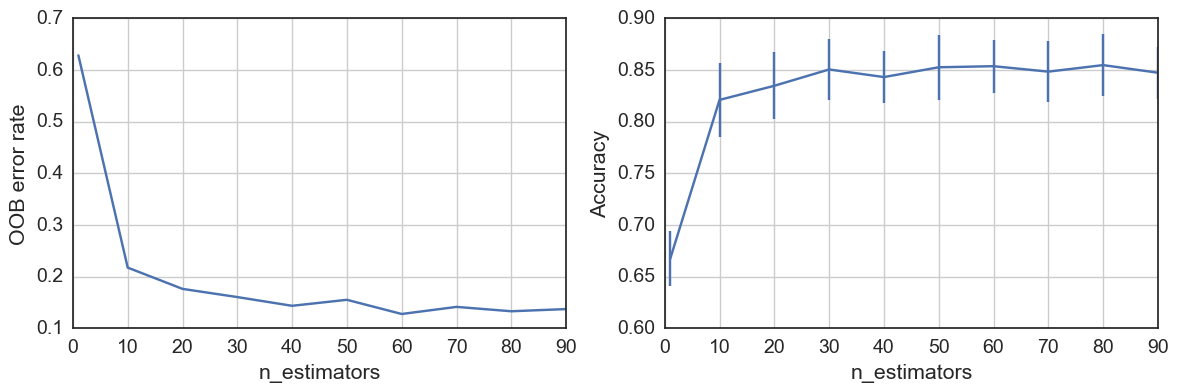

In [57]:
test_n_estimators(sub_periodic[FATS_feats_non], sub_periodic['Var_Type'])

Max depth =  [ 1  2  4  6  8 10 12 14 16 18]


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.5s finished


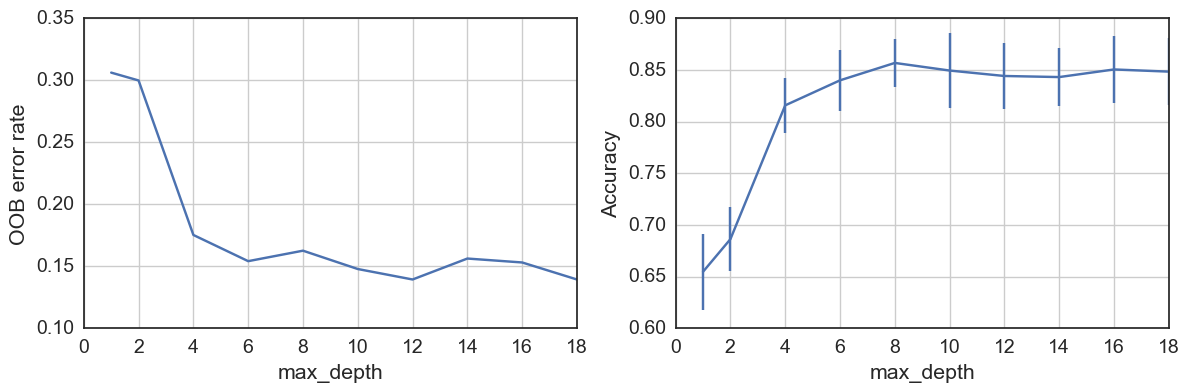

In [58]:
test_n_estimators(sub_periodic[FATS_feats_non], sub_periodic['Var_Type'],
                  hiperparam='max_depth', test_range=np.arange(0,20,2))

In [31]:
RFC = RandomForestClassifier(n_estimators=40, criterion='entropy',
                           max_features='sqrt', max_depth=10, n_jobs=2,
                            min_samples_leaf=1, oob_score=False,
                            class_weight='balanced')


ss = model_selection.StratifiedShuffleSplit(n_splits=10, train_size=2./3.,
                                            random_state=10)

scores = model_selection.cross_val_score(RFC, sub_periodic[FATS_feats_non], sub_periodic['Var_Type'], 
                                         scoring='f1_macro', cv=ss, n_jobs=2, verbose=1)
clases = list(set(sub_periodic['Var_Type']))

pred_y = model_selection.cross_val_predict(RFC, sub_periodic[FATS_feats_non],
                                               sub_periodic['Var_Type'], cv=10, n_jobs=2, verbose=1)
pred_prob = model_selection.cross_val_predict(RFC, sub_periodic[FATS_feats_non],
                                               sub_periodic['Var_Type'], method='predict_proba',
                                              cv=10, n_jobs=2,verbose=1)

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.5s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.7s finished


Accuracy =  0.835924439705 +- 0.035480681657
             precision    recall  f1-score   support

       DSCT       0.93      0.93      0.93       150
         EB       0.79      0.88      0.83       311
     ROTVAR       0.81      0.71      0.76       168
      RRLYR       0.88      0.83      0.85       277

avg / total       0.84      0.84      0.84       906



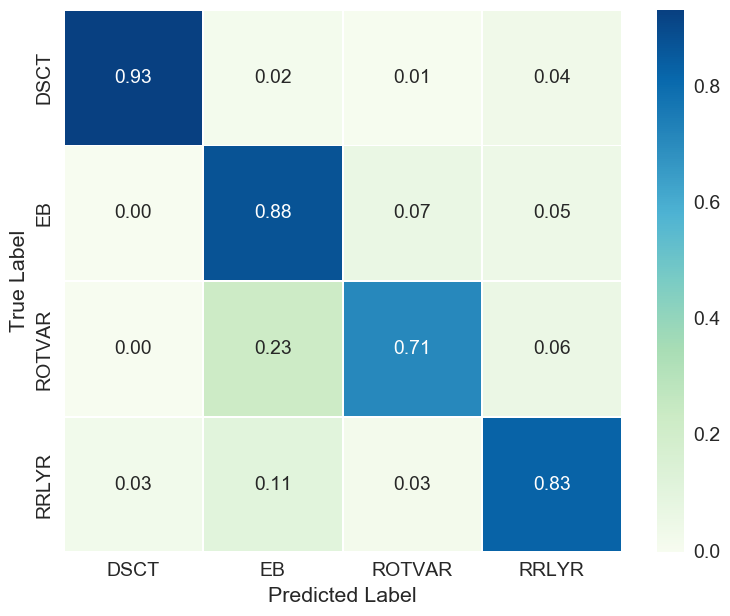

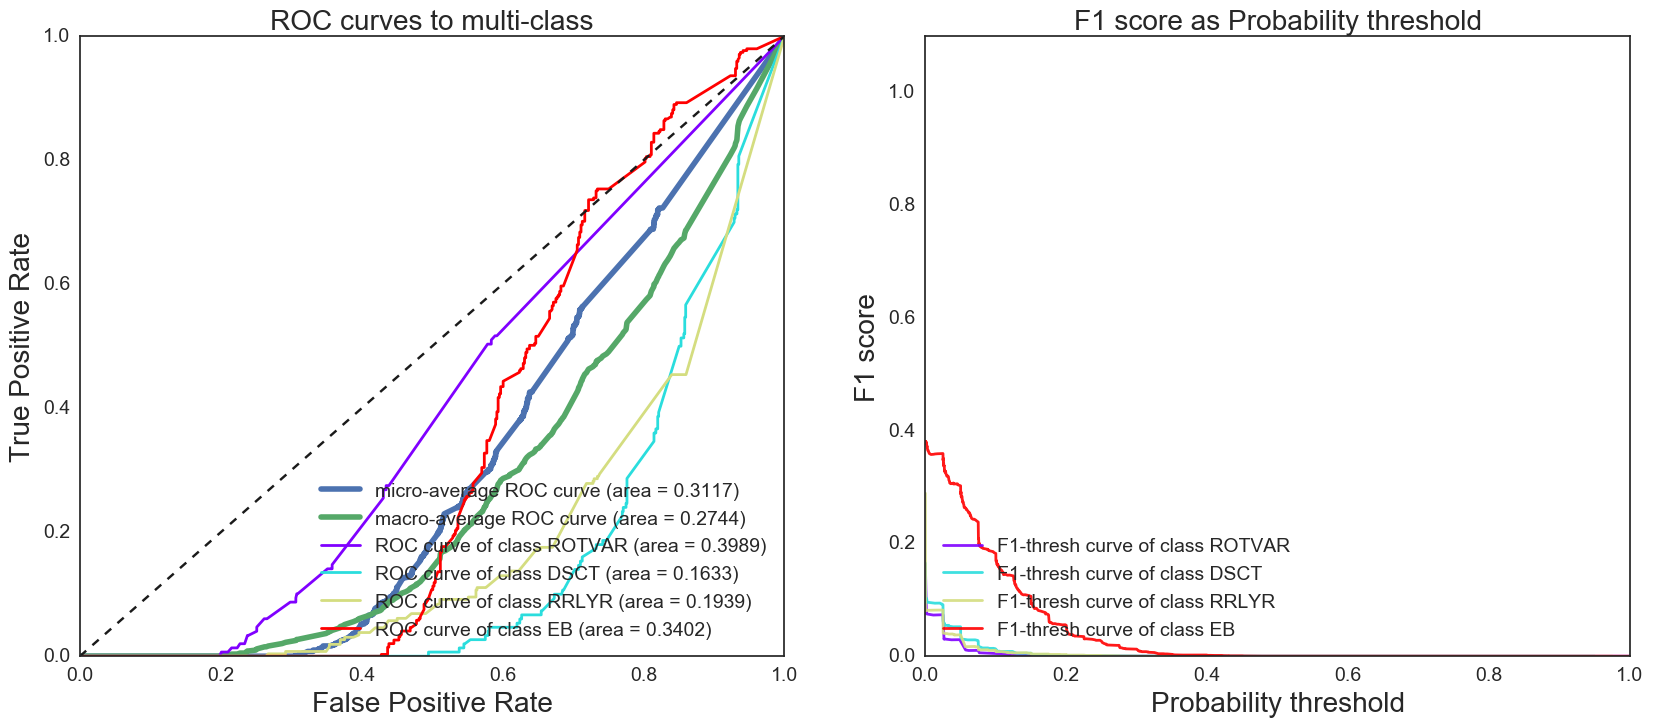

In [32]:
print "Accuracy = ", scores.mean(), "+-", scores.std()
print metrics.classification_report(sub_periodic['Var_Type'], pred_y)

save_path = '%s/figures/conf_matrix_per_subcls_RFC.pdf' % (mainpath)
conf_matrix(true=sub_periodic['Var_Type'], predict=pred_y, 
            classes=clases, save=save_path, normalized=True)
ROC_F1_thresh_curves_multiclass(pred_y, y_score=pred_prob, classes=clases)

In [33]:
RFC_subper_save = RandomForestClassifier(n_estimators=40, criterion='entropy',
                           max_features='sqrt', max_depth=10, n_jobs=2,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced_subsample')

RFC_subper_save.fit(sub_periodic[FATS_feats_non], sub_periodic['Var_Type'])
joblib.dump(RFC_subper_save, '%s/models/RFC_periodics_subclasses_DA.pkl' % mainpath) 
feat_imp = pd.DataFrame(np.array([FATS_feats_non, RFC_subper_save.feature_importances_]).T,
                        columns=['feat_name','feat_score'])
feat_imp.sort_values('feat_score', ascending=False).head(10)

,feat_name,feat_score
38,Gskew,0.0834042
49,PeriodLS,0.0764863
56,Skew,0.0701199
42,Meanvariance,0.0584373
47,PercentDifferenceFluxPercentile,0.0563863
40,MaxSlope,0.0490941
51,Period_fit,0.0487848
14,Freq1_harmonics_amplitude_0,0.0428621
57,SlottedA_length,0.0341624
59,Std,0.033008


### NonPeriodic subclasses

In [49]:
label_samp_varonly_nonP = label_samp_varonly.query('Var_Type == "QSO" or \
                                                    Var_Type == "CV" or \
                                                    Var_Type == "SNe"')
print label_samp_varonly_nonP.Var_Type.value_counts()

CV     94
QSO    72
SNe    12
Name: Var_Type, dtype: int64


In [50]:
label_samp_varonly_nonP.dropna(subset=FATS_feats_all).Var_Type.value_counts()

QSO    57
CV     49
SNe     8
Name: Var_Type, dtype: int64

N estimators =  [ 1 10 20 30 40 50 60 70 80 90]


/Users/jorgetil/miniconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=3)]: Done   5 out of  10 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.6s finished
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/

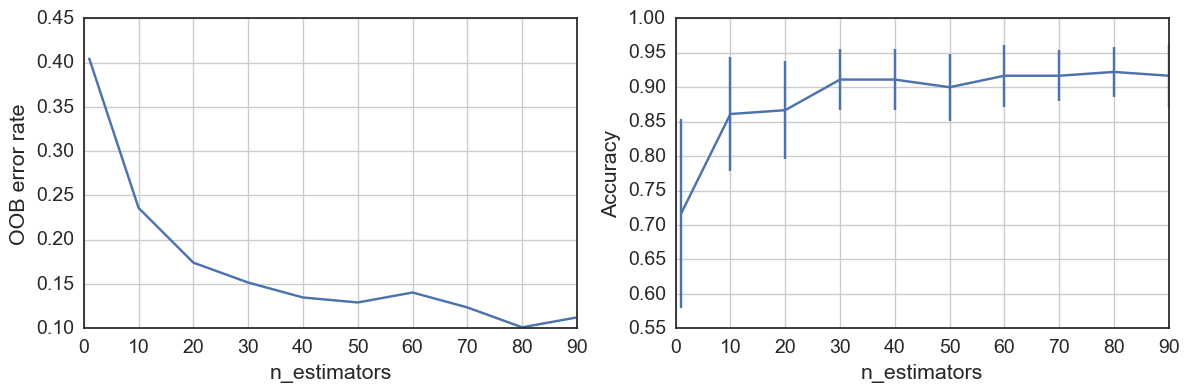

In [53]:
test_n_estimators(label_samp_varonly_nonP[FATS_feats_non],
                                         label_samp_varonly_nonP['Var_Type'])

Max depth =  [ 1  2  4  6  8 10 12 14 16 18]


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.4s finished


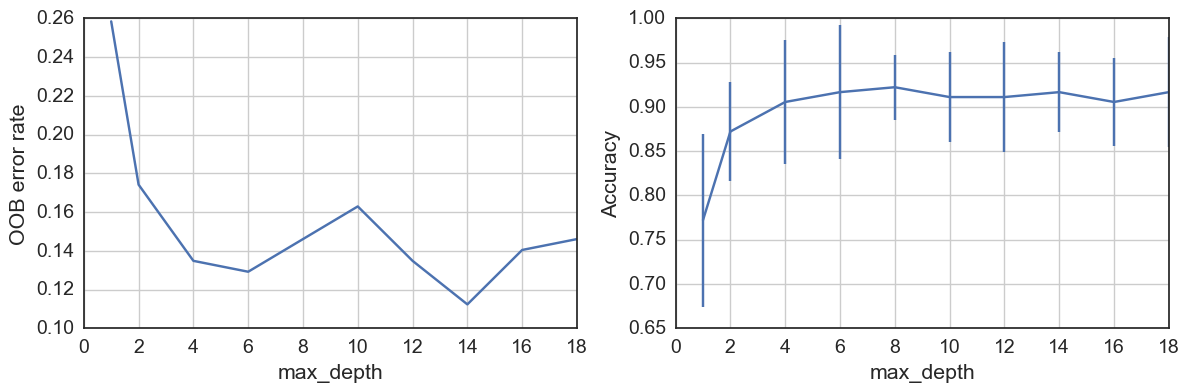

In [54]:
test_n_estimators(label_samp_varonly_nonP[FATS_feats_non], label_samp_varonly_nonP['Var_Type'],
                  hiperparam='max_depth', test_range=np.arange(0,20,2))

In [61]:
RFC = RandomForestClassifier(n_estimators=40, criterion='entropy',
                           max_features='sqrt', max_depth=8, n_jobs=2,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced_subsample')

ss = model_selection.StratifiedKFold(n_splits=6, random_state=10)

scores = model_selection.cross_val_score(RFC, label_samp_varonly_nonP[FATS_feats_non],
                                         label_samp_varonly_nonP['Var_Type'], 
                                         scoring='f1_weighted', cv=ss, n_jobs=2, verbose=1)
clases = list(set(label_samp_varonly_nonP['Var_Type']))
prediction = model_selection.cross_val_predict(RFC, label_samp_varonly_nonP[FATS_feats_non],
                                   label_samp_varonly_nonP['Var_Type'], cv=10, n_jobs=2,
                                                 verbose=1, method='predict')

[Parallel(n_jobs=2)]: Done   6 out of   6 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    2.6s finished


F-1 =  0.867499009116 +- 0.121205243489
             precision    recall  f1-score   support

         CV       0.88      0.96      0.92        94
        QSO       0.89      0.82      0.86        72
        SNe       0.80      0.67      0.73        12

avg / total       0.88      0.88      0.88       178



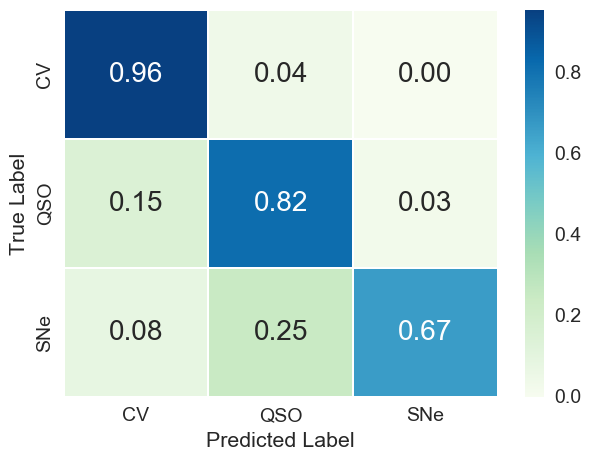

In [62]:
print "F-1 = ", np.median(scores), "+-", mad(scores)
print metrics.classification_report(label_samp_varonly_nonP['Var_Type'], prediction)
save_path = '%s/figures/conf_matrix_nonper_subclasses.pdf' % (mainpath)
conf_matrix(true=label_samp_varonly_nonP['Var_Type'], predict=prediction, 
            classes=clases, save=save_path, normalized=True)

In [64]:
RFC_subNONper_save = RandomForestClassifier(n_estimators=40, criterion='entropy',
                           max_features='sqrt', max_depth=8, n_jobs=2,
                            min_samples_leaf=1, oob_score=True,
                            class_weight='balanced_subsample')

RFC_subNONper_save.fit(label_samp_varonly_nonP[FATS_feats_non], label_samp_varonly_nonP['Var_Type'])
joblib.dump(RFC_subNONper_save, '%s/models/RFC_nonperiodics_subclasses_DA.pkl' % mainpath) 
feat_imp = pd.DataFrame(np.array([FATS_feats_non, RFC_subNONper_save.feature_importances_]).T,
                        columns=['feat_name','feat_score'])
feat_imp.sort_values('feat_score', ascending=False).head(10)

,feat_name,feat_score
39,LinearTrend,0.0734407
2,Autocor_length,0.0679641
0,Amplitude,0.0514052
53,Psi_eta,0.0489767
55,Rcs,0.044822
49,PeriodLS,0.0384035
17,Freq1_harmonics_amplitude_3,0.0370569
42,Meanvariance,0.0365344
54,Q31,0.0358069
15,Freq1_harmonics_amplitude_1,0.0346048


# Final Classifier

In [298]:
final_test_sample = tree_test.copy().query('~(Var_Type == "ZZ" or Var_Type == "LPV")')
final_test_sample = pd.concat([final_test_sample, test_synt], axis=0).dropna(subset=FATS_feats_all)
print final_test_sample.Var_Type.value_counts()

QSO       612
RRLYR      74
NV         51
EB         49
CV         24
ROTVAR      6
MISC        3
DSCT        1
SNe         1
Name: Var_Type, dtype: int64


In [299]:
var_pred = RFC_var.predict(final_test_sample[FATS_feats_all])
variables = final_test_sample[var_pred == 1]
non_variables = final_test_sample[var_pred == 0]
non_variables['Prediction'] = 'NV'

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [300]:
periodic_pred = RFC_per.predict(variables[FATS_feats_all])
periodic = variables[periodic_pred == 1]
non_periodic = variables[periodic_pred == 0]

In [301]:
subper_pred = RFC_subper.predict(periodic[FATS_feats_non])
periodic['Prediction'] = subper_pred

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [302]:
subNper_pred = RFC_subnonP.predict(non_periodic[FATS_feats_all])
non_periodic['Prediction'] = subNper_pred

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [303]:
final_predictions = pd.concat([non_variables, periodic, non_periodic], axis=0)
final_predictions[['Var_Type', 'Prediction']].head(10)
classes = np.unique(final_predictions.Var_Type.values)

             precision    recall  f1-score   support

         CV       0.06      0.29      0.10        24
       DSCT       0.00      0.00      0.00         1
         EB       0.87      0.82      0.84        49
       MISC       0.00      0.00      0.00         3
         NV       0.69      0.98      0.81        51
        QSO       0.95      0.78      0.86       612
     ROTVAR       0.20      0.50      0.29         6
      RRLYR       0.98      0.82      0.90        74
        SNe       0.00      0.00      0.00         1

avg / total       0.89      0.78      0.83       821

Macro-Precision score: 0.417049969013
Accuracy score: 0.780755176614


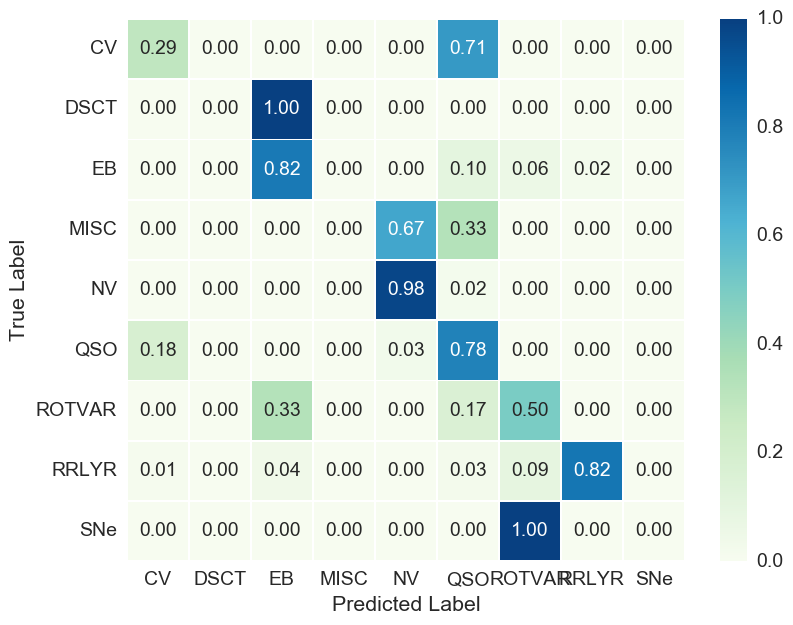

In [304]:
print metrics.classification_report(final_predictions['Var_Type'], final_predictions['Prediction'])

print 'Macro-Precision score:',
print metrics.precision_score(final_predictions['Var_Type'], final_predictions['Prediction'], average='macro')
print 'Accuracy score:',
print metrics.accuracy_score(final_predictions['Var_Type'], final_predictions['Prediction'])

save_path = '%s/figures/conf_matrix_treeTest_RFC.pdf' % (mainpath)
conf_matrix(true=final_predictions['Var_Type'], predict=final_predictions['Prediction'], 
            classes=classes, save=save_path, normalized=True)

## Multiclass RF after all the cleaning

### How meny estimators?

In [64]:
test_n_estimators(syn_sample[FATS_feats_non], syn_sample['Var_Type'])

N estimators =  [ 1 10 20 30 40 50 60 70 80 90]


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

### tree depth

Max depth =  [ 1  2  4  6  8 10 12 14 16 18]


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    7.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    6.8s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   10.0s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   14.9s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   14.6s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   15.6s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   16.2s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   16.4s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   16.9s finished
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   16.5s finished


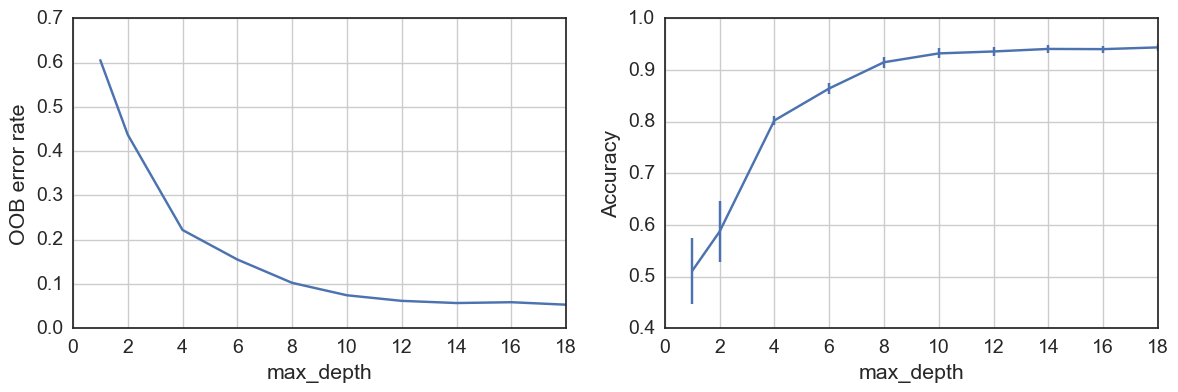

In [140]:
test_n_estimators(syn_sample[FATS_feats_non], syn_sample['Var_Type'],
                  hiperparam='max_depth', test_range=np.arange(0,20,2))

### grid search

In [141]:
# split data with Stratified Shuffle Split
ss = model_selection.StratifiedShuffleSplit(n_splits=10, train_size=2./3.,
                                            random_state=10)
# Grid of params for RF
param_grid = {"max_depth": [10],
              "max_features": ['sqrt','log2'],
              "min_samples_split": [2,4,8],
              "min_samples_leaf": [1,3,5],
              "bootstrap": [True],
              "criterion": ["gini", "entropy"],
              "n_estimators": [40],
              "class_weight": ['balanced_subsample', 'balanced']}

# initialize RFC
rf_clf = RandomForestClassifier()
# initialize grid search
grid_search = model_selection.GridSearchCV(rf_clf, param_grid=param_grid, cv=ss,
                           n_jobs=4, verbose=1)
# fit data
grid_search.fit(syn_sample[FATS_feats_non], syn_sample['Var_Type'])

print "The best classifier is: ", grid_search.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   38.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  6.4min
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed: 10.2min finished


The best classifier is:  RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=10, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


## final multi--class RFC

In [150]:
syn_sample = syn_sample.query('~(Var_Type == "LPV" or Var_Type == "MISC")')
syn_sample.Var_Type.value_counts()

NV        5145
QSO       2304
ROTVAR    1076
RRLYR      848
DSCT       834
EB         109
CV          64
SNe         10
Name: Var_Type, dtype: int64

In [151]:
RFC_multi = RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=10, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

ss = model_selection.StratifiedShuffleSplit(n_splits=10, train_size=2./3.,
                                            random_state=10)

scores = model_selection.cross_val_score(RFC_multi, syn_sample[FATS_feats_non_mean],
                                         syn_sample['Var_Type'], 
                                         scoring='f1_weighted', cv=ss, n_jobs=2, verbose=1)
print "Accuracy = ", scores.mean(), "+-", scores.std()

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jorgetil/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy =  0.922335861608 +- 0.00393504628212


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   15.5s finished


In [152]:
clases = list(set(syn_sample['Var_Type']))
predicted_proba = model_selection.cross_val_predict(RFC_multi, syn_sample[FATS_feats_non_mean],
                                   syn_sample['Var_Type'],
                                    cv=10, n_jobs=2, verbose=1, method='predict_proba')
predicted_class = model_selection.cross_val_predict(RFC_multi, syn_sample[FATS_feats_non_mean],
                                   syn_sample['Var_Type'],
                                    cv=10, n_jobs=2, verbose=1, method='predict')

[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   20.0s finished
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   21.4s finished


Accuracy =  0.922335861608 +- 0.00393504628212
             precision    recall  f1-score   support

         CV       0.00      0.00      0.00        64
       DSCT       0.94      0.96      0.95       834
         EB       0.82      0.83      0.83       109
         NV       0.98      0.91      0.94      5145
        QSO       0.81      0.94      0.87      2304
     ROTVAR       0.91      0.94      0.93      1076
      RRLYR       0.92      0.86      0.89       848
        SNe       1.00      0.30      0.46        10

avg / total       0.92      0.92      0.91     10390



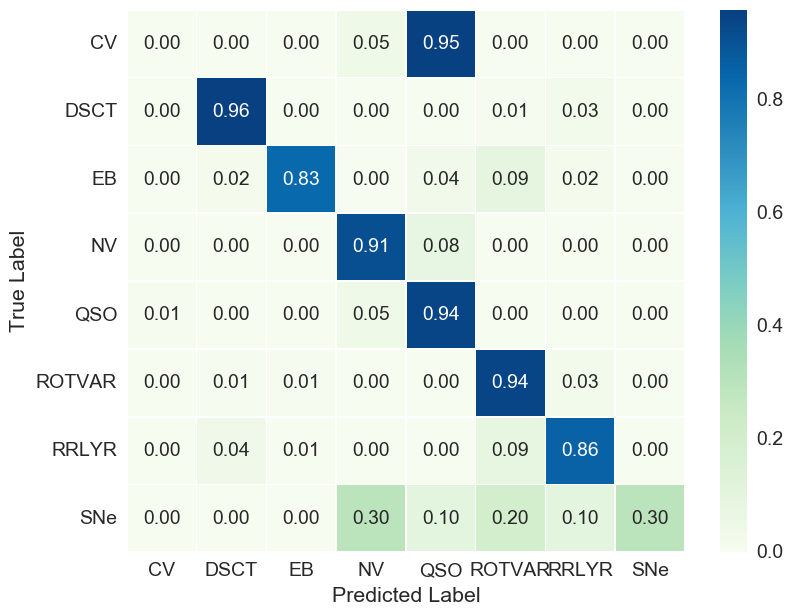

In [153]:
print "Accuracy = ", scores.mean(), "+-", scores.std()
print metrics.classification_report(syn_sample['Var_Type'], predicted_class)

save_path = '%s/figures/conf_matrix_multiclassTest_cleanTS_DAall_RFC_qsodrop.pdf' % (mainpath)
conf_matrix(true=syn_sample['Var_Type'].values, predict=predicted_class, 
            classes=clases, save=save_path, normalized=True)

#PR_ROC_curves_multiclass(predicted_class, predicted_proba, clases)

In [157]:
importance = []
for k in range(10):
    RFC_multi = RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=10, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

    RFC_multi.fit(syn_sample[FATS_feats_non], syn_sample['Var_Type'])
    importance.append(RFC_multi.feature_importances_)

joblib.dump(RFC_multi, '%s/models/RFC_all_multiclass_DAall_balancedclassweight.pkl' % mainpath)

['/Users/jorgetil/Astro/HITS/models/RFC_all_multiclass_DAall_balancedclassweight.pkl']

In [158]:
importance = np.array(importance)
feat_imp = pd.DataFrame(np.array([FATS_feats_non, importance.mean(axis=0)]).T,
                        columns=['feat_name','feat_score'])
feat_imp.sort_values('feat_score', ascending=False).head(10)

,feat_name,feat_score
51,Period_fit,0.0987746
53,Psi_eta,0.0718568
5,CAR_sigma,0.0703048
6,CAR_tau,0.0542508
49,PeriodLS,0.0500849
4,CAR_mean,0.0400192
57,SlottedA_length,0.0365239
14,Freq1_harmonics_amplitude_0,0.0362782
61,StetsonK_AC,0.0325686
41,Mean,0.0318852


In [305]:
FATS_feats_non_mean = FATS_feats_non[(FATS_feats_non != 'Mean') & 
                                     (FATS_feats_non != 'CAR_mean') & 
                                     (FATS_feats_non != 'Meanvariance') &
                                     (FATS_feats_non != 'Q31')]
print FATS_feats_non_mean

['Amplitude' 'AndersonDarling' 'Autocor_length' 'Beyond1Std' 'CAR_sigma'
 'CAR_tau' 'Con' 'Eta_e' 'FluxPercentileRatioMid20'
 'FluxPercentileRatioMid35' 'FluxPercentileRatioMid50'
 'FluxPercentileRatioMid65' 'FluxPercentileRatioMid80'
 'Freq1_harmonics_amplitude_0' 'Freq1_harmonics_amplitude_1'
 'Freq1_harmonics_amplitude_2' 'Freq1_harmonics_amplitude_3'
 'Freq1_harmonics_rel_phase_0' 'Freq1_harmonics_rel_phase_1'
 'Freq1_harmonics_rel_phase_2' 'Freq1_harmonics_rel_phase_3'
 'Freq2_harmonics_amplitude_0' 'Freq2_harmonics_amplitude_1'
 'Freq2_harmonics_amplitude_2' 'Freq2_harmonics_amplitude_3'
 'Freq2_harmonics_rel_phase_0' 'Freq2_harmonics_rel_phase_1'
 'Freq2_harmonics_rel_phase_2' 'Freq2_harmonics_rel_phase_3'
 'Freq3_harmonics_amplitude_0' 'Freq3_harmonics_amplitude_1'
 'Freq3_harmonics_amplitude_2' 'Freq3_harmonics_amplitude_3'
 'Freq3_harmonics_rel_phase_0' 'Freq3_harmonics_rel_phase_1'
 'Freq3_harmonics_rel_phase_2' 'Freq3_harmonics_rel_phase_3' 'Gskew'
 'LinearTrend' 'MaxSlope'

In [298]:
RFC_multi.n_features_

59

In [281]:
importance = np.array(importance)
print importance.mean(axis=0).shape

(60,)
